# Lecture 10 - PyTorch

Since computation is a bottleneck for neural nets, it is worthwhile to learn to construct neural nets with a dedicated deep learning framework rather than simply raw Python with NumPy, as we have used so far, because they allow highly optimized computation accelerated by graphics processing units (GPUs) and let us create nets quickly and easily.

As of now, the most popular solutions are Meta's PyTorch and Google's TensorFlow with Keras. (There are some other solutions like Theano, Caffe, JAX, and MXNet as well.) Both have two main parts: (1) highly optimized tensor computing, including matrix multiplication and (2) simple functionality for creating neural networks with optimized backpropagation.

We will use PyTorch today.

## GPU Computing

Neural networks benefit from parallelization with GPUs, and PyTorch can handle this for us. A GPU can be in your local device or in a cloud. The following code can check if PyTorch sees a GPU.

In [1]:
import torch

# Check the number of GPUs available
numGPUs = torch.cuda.device_count()

print('Num GPUs Available: ', numGPUs)

# Loop through all detected GPUs and print their details
for i in range(numGPUs):
    print(f'GPU {i} Device Name: {torch.cuda.get_device_name(i)}')
    device_properties = torch.cuda.get_device_properties(i)
    print(f'GPU {i} Device Info: {device_properties}')

Num GPUs Available:  2
GPU 0 Device Name: NVIDIA GeForce RTX 3090
GPU 0 Device Info: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24575MB, multi_processor_count=82)
GPU 1 Device Name: NVIDIA GeForce RTX 3090
GPU 1 Device Info: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24575MB, multi_processor_count=82)


If there is a GPU on the device running the notebook, this prints the name of it. Otherwise, it prints that there are no GPUs available. (Note that, for PyTorch to see and use a GPU in your local device, you must install NVIDIA's CUDA parallel computing platform and some drivers.)

Torch automatically exploits GPU resources quite efficiently, so it's not something that requires extra effort on our side. This means we have several layers of abstraction: PyTorch makes calls to CUDA, which runs on C/C++. So, it is unrealistic to expect the whole path makes *everything* run optimally with absolute maximum efficiency, but, in practice, it is pretty close! However, I did want to point out that it can be worthwhile to customize lower-level code or manage parallelization with raw CUDA code. None of this is particularly difficult, and CUDA customization is usually unnecessary, but it can be done.

### Writing a Fully-connected Feedforward Neural Net with Torch

We will aim to write a neural net similar to what we have constructed through the course so far. That is, it should feed data forward through a sequence of layers, the layers should be fully connected (dense), and we should use SGD to optimize it. We can import these things directly from Torch.

In [27]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchsummary import summary
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

import matplotlib.pyplot as plt

Let's construct the net to classify MNIST (our beloved benchmarking dataset) on a vanilla neural network (SGD, sigmoid, SSE loss) with two hidden layers

In [5]:
# Define the model with ReLU
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)  # Convert output to probabilities for MSE loss
)

# Loss function (MSELoss)
criterion = nn.MSELoss()

# Adam optimizer with L2 regularization (weight_decay is the L2 penalty)
optimizer = optim.SGD(model.parameters(), lr=0.5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
           Softmax-7                   [-1, 10]               0
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


Now, let's read in MNIST and train our vanilla net to classify it.

In [6]:
# Load the MNIST dataset using torchvision
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,), (0.5,))])

# Download and load the training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Let's write some functions to train and test the model.

In [7]:
def one_hot_encoding(targets, num_classes=10, device='cpu'):
    # Generate one-hot encoding and move it to the same device as targets
    return torch.eye(num_classes, device=device)[targets]

# Train function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # One-hot encode the target
        target_one_hot = one_hot_encoding(target, num_classes=10, device=device)  # Pass the correct device
        
        # Calculate loss with MSE
        loss = criterion(output, target_one_hot)
        loss.backward()
        optimizer.step()
        
        # Track loss
        train_loss += loss.item()
        
        # Track accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total
    return avg_train_loss, train_accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # One-hot encode the target
            target_one_hot = one_hot_encoding(target, num_classes=10, device=device)  # Pass the correct device
            
            # Calculate loss with MSE
            test_loss += criterion(output, target_one_hot).item()
            
            # Track accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)
    return avg_test_loss, test_accuracy

Train the Model

In [8]:
# Training loop
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    avg_test_loss, test_accuracy = test(model, device, test_loader)
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch}: \tTrain Loss: {avg_train_loss:.4f} \tTest Loss: {avg_test_loss:.4f}'
          + f'\tTrain Accuracy: {train_accuracy:.4f}, \tTest Accuracy: {test_accuracy:.4f}')

Epoch 0: 	Train Loss: 0.0469 	Test Loss: 0.0187	Train Accuracy: 0.6640, 	Test Accuracy: 0.8833
Epoch 1: 	Train Loss: 0.0164 	Test Loss: 0.0137	Train Accuracy: 0.8947, 	Test Accuracy: 0.9120
Epoch 2: 	Train Loss: 0.0137 	Test Loss: 0.0125	Train Accuracy: 0.9109, 	Test Accuracy: 0.9197
Epoch 3: 	Train Loss: 0.0123 	Test Loss: 0.0111	Train Accuracy: 0.9194, 	Test Accuracy: 0.9288
Epoch 4: 	Train Loss: 0.0111 	Test Loss: 0.0101	Train Accuracy: 0.9280, 	Test Accuracy: 0.9348
Epoch 5: 	Train Loss: 0.0102 	Test Loss: 0.0093	Train Accuracy: 0.9353, 	Test Accuracy: 0.9391
Epoch 6: 	Train Loss: 0.0093 	Test Loss: 0.0096	Train Accuracy: 0.9404, 	Test Accuracy: 0.9380
Epoch 7: 	Train Loss: 0.0084 	Test Loss: 0.0080	Train Accuracy: 0.9466, 	Test Accuracy: 0.9482
Epoch 8: 	Train Loss: 0.0078 	Test Loss: 0.0078	Train Accuracy: 0.9506, 	Test Accuracy: 0.9482
Epoch 9: 	Train Loss: 0.0072 	Test Loss: 0.0072	Train Accuracy: 0.9550, 	Test Accuracy: 0.9522
Epoch 10: 	Train Loss: 0.0066 	Test Loss: 0.0067	T

Plot the Results

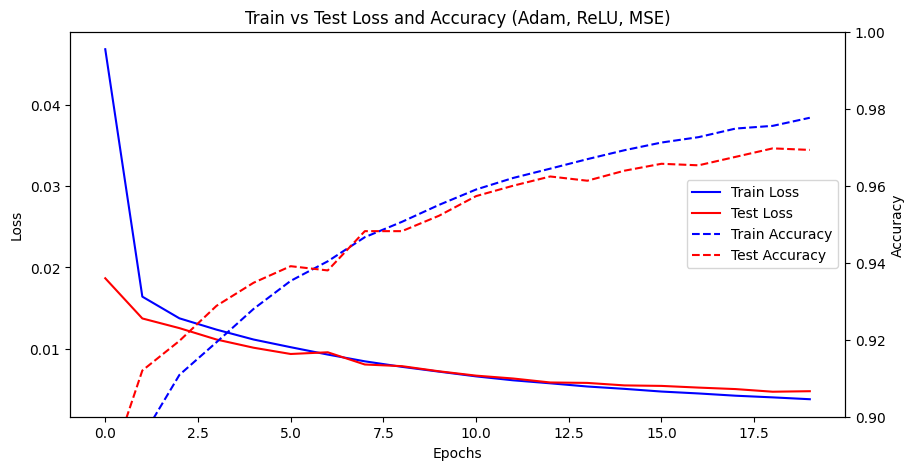

In [9]:
# Plot Train Loss vs Test Loss and Train Accuracy vs Test Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting Train and Test Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')

train_loss_line, = ax1.plot(train_losses, label='Train Loss', color='blue')
test_loss_line, = ax1.plot(test_losses, label='Test Loss', color='red')

ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='black')

ax2.set_ylim(0.9, 1)  # Set the right axis for accuracy from 0.9 to 1

train_acc_line, = ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
test_acc_line, = ax2.plot(test_accuracies, label='Test Accuracy', color='red', linestyle='--')

ax2.tick_params(axis='y')

# Adding legend for both axes
lines = [train_loss_line, test_loss_line, train_acc_line, test_acc_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

# Title for the plot
plt.title('Train vs Test Loss and Accuracy (Adam, ReLU, MSE)')
plt.show()

Let's try a more modern version using ReLU layers with crossentropy loss, the ADAM optimizer, and and $L^2$ regularization. The `torch` implementation of the crossentropy loss handles the data shapes and output normalization by itself, so we do not need to manually add the softmax or one-hot the data.

In [10]:
# Define the model with ReLU
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)  # No softmax here; CrossEntropyLoss expects raw logits
)

# Use CrossEntropyLoss instead of MSELoss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with L2 regularization (weight_decay is the L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


Let's use this more modern network to classify MNIST

In [11]:
# Train function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss with CrossEntropyLoss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Track loss
        train_loss += loss.item()
        
        # Track accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total
    return avg_train_loss, train_accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate loss with CrossEntropyLoss
            test_loss += criterion(output, target).item()
            
            # Track accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)
    return avg_test_loss, test_accuracy

In [12]:
# Training loop
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    avg_test_loss, test_accuracy = test(model, device, test_loader)
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch}: \tTrain Loss: {avg_train_loss:.4f} \tTest Loss: {avg_test_loss:.4f}'
          + f'\tTrain Accuracy: {train_accuracy:.4f}, \tTest Accuracy: {test_accuracy:.4f}')

Epoch 0: 	Train Loss: 0.4029 	Test Loss: 0.2171	Train Accuracy: 0.8813, 	Test Accuracy: 0.9349
Epoch 1: 	Train Loss: 0.1843 	Test Loss: 0.1489	Train Accuracy: 0.9450, 	Test Accuracy: 0.9524
Epoch 2: 	Train Loss: 0.1302 	Test Loss: 0.1076	Train Accuracy: 0.9607, 	Test Accuracy: 0.9665
Epoch 3: 	Train Loss: 0.1017 	Test Loss: 0.0993	Train Accuracy: 0.9689, 	Test Accuracy: 0.9693
Epoch 4: 	Train Loss: 0.0857 	Test Loss: 0.1125	Train Accuracy: 0.9733, 	Test Accuracy: 0.9653
Epoch 5: 	Train Loss: 0.0747 	Test Loss: 0.0975	Train Accuracy: 0.9767, 	Test Accuracy: 0.9700
Epoch 6: 	Train Loss: 0.0643 	Test Loss: 0.0813	Train Accuracy: 0.9795, 	Test Accuracy: 0.9744
Epoch 7: 	Train Loss: 0.0594 	Test Loss: 0.0753	Train Accuracy: 0.9809, 	Test Accuracy: 0.9764
Epoch 8: 	Train Loss: 0.0547 	Test Loss: 0.0830	Train Accuracy: 0.9822, 	Test Accuracy: 0.9757
Epoch 9: 	Train Loss: 0.0460 	Test Loss: 0.0734	Train Accuracy: 0.9855, 	Test Accuracy: 0.9764
Epoch 10: 	Train Loss: 0.0459 	Test Loss: 0.0713	T

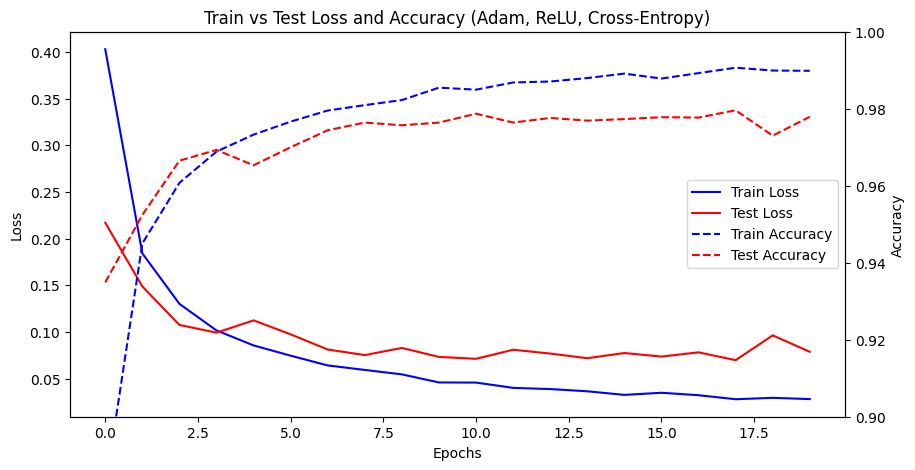

In [13]:
# Plot Train Loss vs Test Loss and Train Accuracy vs Test Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting Train and Test Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')

train_loss_line, = ax1.plot(train_losses, label='Train Loss', color='blue')
test_loss_line, = ax1.plot(test_losses, label='Test Loss', color='red')

ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='black')

ax2.set_ylim(0.9, 1)  # Set the right axis for accuracy from 0.9 to 1

train_acc_line, = ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
test_acc_line, = ax2.plot(test_accuracies, label='Test Accuracy', color='red', linestyle='--')

ax2.tick_params(axis='y')

# Adding legend for both axes
lines = [train_loss_line, test_loss_line, train_acc_line, test_acc_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

# Title for the plot
plt.title('Train vs Test Loss and Accuracy (Adam, ReLU, Cross-Entropy)')
plt.show()

As expected, this is a bit better.

Next, let's try a more challenging dataset: CIFAR-10.

In [14]:
# CIFAR-10 dataset preprocessing (No augmentation, just normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalization for CIFAR-10
])

# Load CIFAR-10 data
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Define the model with ReLU (input size adjusted to 3072 for CIFAR-10)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 256),  # Input size is now 3072 (32x32x3)
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)  # Output size remains 10 for CIFAR-10 classes
)

# Use CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer with L2 regularization (weight_decay is the L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 3.13
Estimated Total Size (MB): 3.17
----------------------------------------------------------------


In [16]:
# Training loop
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    avg_test_loss, test_accuracy = test(model, device, test_loader)
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch}: \tTrain Loss: {avg_train_loss:.4f} \tTest Loss: {avg_test_loss:.4f}'
          + f'\tTrain Accuracy: {train_accuracy:.4f}, \tTest Accuracy: {test_accuracy:.4f}')

Epoch 0: 	Train Loss: 1.6558 	Test Loss: 1.5123	Train Accuracy: 0.4122, 	Test Accuracy: 0.4617
Epoch 1: 	Train Loss: 1.4587 	Test Loss: 1.4951	Train Accuracy: 0.4850, 	Test Accuracy: 0.4725
Epoch 2: 	Train Loss: 1.3713 	Test Loss: 1.4278	Train Accuracy: 0.5202, 	Test Accuracy: 0.5039
Epoch 3: 	Train Loss: 1.3001 	Test Loss: 1.4188	Train Accuracy: 0.5397, 	Test Accuracy: 0.5085
Epoch 4: 	Train Loss: 1.2432 	Test Loss: 1.4129	Train Accuracy: 0.5602, 	Test Accuracy: 0.5054
Epoch 5: 	Train Loss: 1.1933 	Test Loss: 1.4465	Train Accuracy: 0.5763, 	Test Accuracy: 0.5047
Epoch 6: 	Train Loss: 1.1503 	Test Loss: 1.4466	Train Accuracy: 0.5928, 	Test Accuracy: 0.5076
Epoch 7: 	Train Loss: 1.1090 	Test Loss: 1.3990	Train Accuracy: 0.6072, 	Test Accuracy: 0.5282
Epoch 8: 	Train Loss: 1.0682 	Test Loss: 1.4496	Train Accuracy: 0.6207, 	Test Accuracy: 0.5146
Epoch 9: 	Train Loss: 1.0375 	Test Loss: 1.4425	Train Accuracy: 0.6319, 	Test Accuracy: 0.5175
Epoch 10: 	Train Loss: 1.0031 	Test Loss: 1.4772	T

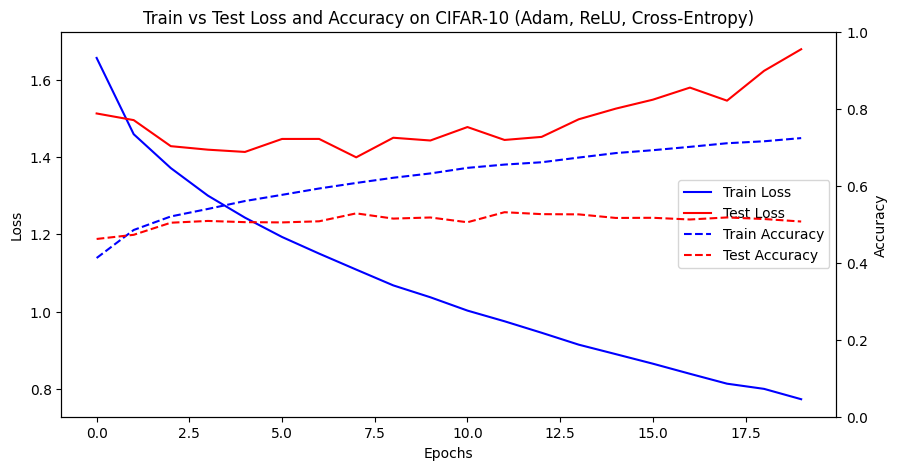

In [17]:
# Plot Train Loss vs Test Loss and Train Accuracy vs Test Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting Train and Test Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')

train_loss_line, = ax1.plot(train_losses, label='Train Loss', color='blue')
test_loss_line, = ax1.plot(test_losses, label='Test Loss', color='red')

ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='black')

ax2.set_ylim(0.0, 1.0)  # Set the right axis for accuracy from 0 to 1

train_acc_line, = ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
test_acc_line, = ax2.plot(test_accuracies, label='Test Accuracy', color='red', linestyle='--')

ax2.tick_params(axis='y')

# Adding legend for both axes
lines = [train_loss_line, test_loss_line, train_acc_line, test_acc_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

# Title for the plot
plt.title('Train vs Test Loss and Accuracy on CIFAR-10 (Adam, ReLU, Cross-Entropy)')
plt.show()

This overfits pretty badly, so let's try dropout.

In [18]:
# Define the model with ReLU (input size adjusted to 3072 for CIFAR-10)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 256),  # Input size is now 3072 (32x32x3)
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 10)  # Output size remains 10 for CIFAR-10 classes
)

# Use CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer with L2 regularization (weight_decay is the L2 penalty)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 3.13
Estimated Total Size (MB): 3.18
----------------------------------------------------------------


In [19]:
# Training loop
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    avg_test_loss, test_accuracy = test(model, device, test_loader)
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch}: \tTrain Loss: {avg_train_loss:.4f} \tTest Loss: {avg_test_loss:.4f}'
          + f'\tTrain Accuracy: {train_accuracy:.4f}, \tTest Accuracy: {test_accuracy:.4f}')

Epoch 0: 	Train Loss: 1.9385 	Test Loss: 1.7258	Train Accuracy: 0.3049, 	Test Accuracy: 0.3972
Epoch 1: 	Train Loss: 1.8143 	Test Loss: 1.7015	Train Accuracy: 0.3508, 	Test Accuracy: 0.4157
Epoch 2: 	Train Loss: 1.7775 	Test Loss: 1.6350	Train Accuracy: 0.3641, 	Test Accuracy: 0.4185
Epoch 3: 	Train Loss: 1.7576 	Test Loss: 1.6085	Train Accuracy: 0.3707, 	Test Accuracy: 0.4456
Epoch 4: 	Train Loss: 1.7414 	Test Loss: 1.6098	Train Accuracy: 0.3795, 	Test Accuracy: 0.4303
Epoch 5: 	Train Loss: 1.7280 	Test Loss: 1.5772	Train Accuracy: 0.3847, 	Test Accuracy: 0.4508
Epoch 6: 	Train Loss: 1.7136 	Test Loss: 1.5790	Train Accuracy: 0.3892, 	Test Accuracy: 0.4442
Epoch 7: 	Train Loss: 1.7052 	Test Loss: 1.6059	Train Accuracy: 0.3931, 	Test Accuracy: 0.4366
Epoch 8: 	Train Loss: 1.7005 	Test Loss: 1.5615	Train Accuracy: 0.3932, 	Test Accuracy: 0.4467
Epoch 9: 	Train Loss: 1.6909 	Test Loss: 1.5670	Train Accuracy: 0.3958, 	Test Accuracy: 0.4540
Epoch 10: 	Train Loss: 1.6818 	Test Loss: 1.5472	T

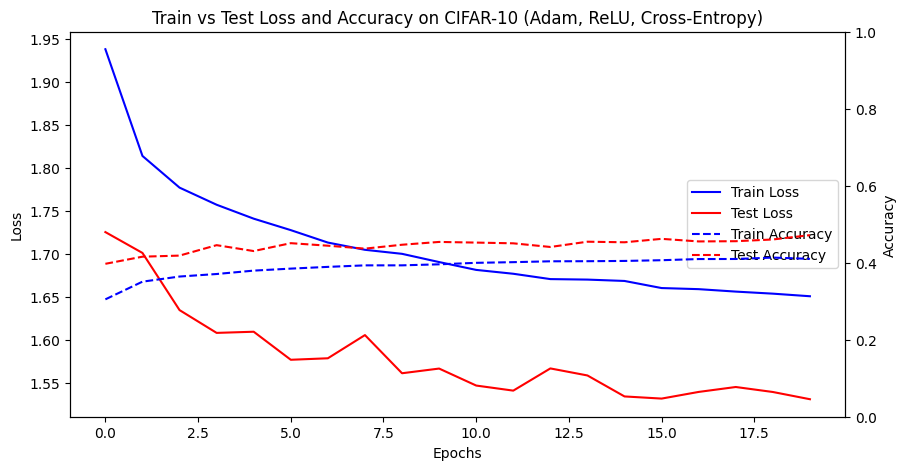

In [20]:
# Plot Train Loss vs Test Loss and Train Accuracy vs Test Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting Train and Test Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')

train_loss_line, = ax1.plot(train_losses, label='Train Loss', color='blue')
test_loss_line, = ax1.plot(test_losses, label='Test Loss', color='red')

ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='black')

ax2.set_ylim(0.0, 1.0)  # Set the right axis for accuracy from 0 to 1

train_acc_line, = ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
test_acc_line, = ax2.plot(test_accuracies, label='Test Accuracy', color='red', linestyle='--')

ax2.tick_params(axis='y')

# Adding legend for both axes
lines = [train_loss_line, test_loss_line, train_acc_line, test_acc_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

# Title for the plot
plt.title('Train vs Test Loss and Accuracy on CIFAR-10 (Adam, ReLU, Cross-Entropy)')
plt.show()

# Lecture 11

In [39]:
# CIFAR-10 dataset preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split dataset into 60/20/20
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
# Define the LeNetReg model with Dropout and regularization
class LeNetReg(nn.Module):
    def __init__(self, height, width, depth, classes, dropout=[0, 0, 0, 0.5]):
        super(LeNetReg, self).__init__()
        
        # Sequential model for layers
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=(5, 5), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(dropout[0]),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(dropout[1]),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout[2]),
            
            nn.Flatten(),
            nn.Linear(in_features=(128 * 8 * 8), out_features=500),  # Adjust for the size after pooling
            nn.ReLU(),
            nn.Dropout(dropout[3]),
            
            nn.Linear(500, classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNetReg(height=32, width=32, depth=3, classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss with CrossEntropyLoss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    print(f'Train Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

# Validation function
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

In [45]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          51,264
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]         204,928
             ReLU-10            [-1, 128, 8, 8]               0
          Dropout-11            [-1, 128, 8, 8]               0
          Flatten-12                 [-1, 8192]               0
           Linear-13                  [-1, 500]       4,096,500
             ReLU-14                  [

In [41]:
# Training and validation loop
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_accuracy = validate(model, device, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print('\n')

# Test the model on the test set
test_loss, test_accuracy = test(model, device, test_loader)

Train Epoch: 0, Loss: 2.1647, Accuracy: 0.2802
Validation Loss: 2.1234, Accuracy: 0.3312


Train Epoch: 1, Loss: 2.0806, Accuracy: 0.3733
Validation Loss: 2.0105, Accuracy: 0.4445


Train Epoch: 2, Loss: 2.0347, Accuracy: 0.4209
Validation Loss: 1.9938, Accuracy: 0.4613


Train Epoch: 3, Loss: 1.9928, Accuracy: 0.4629
Validation Loss: 1.9607, Accuracy: 0.4976


Train Epoch: 4, Loss: 1.9615, Accuracy: 0.4962
Validation Loss: 1.9455, Accuracy: 0.5129


Train Epoch: 5, Loss: 1.9362, Accuracy: 0.5212
Validation Loss: 1.9334, Accuracy: 0.5224


Train Epoch: 6, Loss: 1.9233, Accuracy: 0.5355
Validation Loss: 1.9121, Accuracy: 0.5466


Train Epoch: 7, Loss: 1.8984, Accuracy: 0.5609
Validation Loss: 1.8935, Accuracy: 0.5633


Train Epoch: 8, Loss: 1.8850, Accuracy: 0.5735
Validation Loss: 1.8875, Accuracy: 0.5722


Train Epoch: 9, Loss: 1.8646, Accuracy: 0.5950
Validation Loss: 1.9033, Accuracy: 0.5536


Train Epoch: 10, Loss: 1.8530, Accuracy: 0.6050
Validation Loss: 1.8612, Accuracy: 0.5960


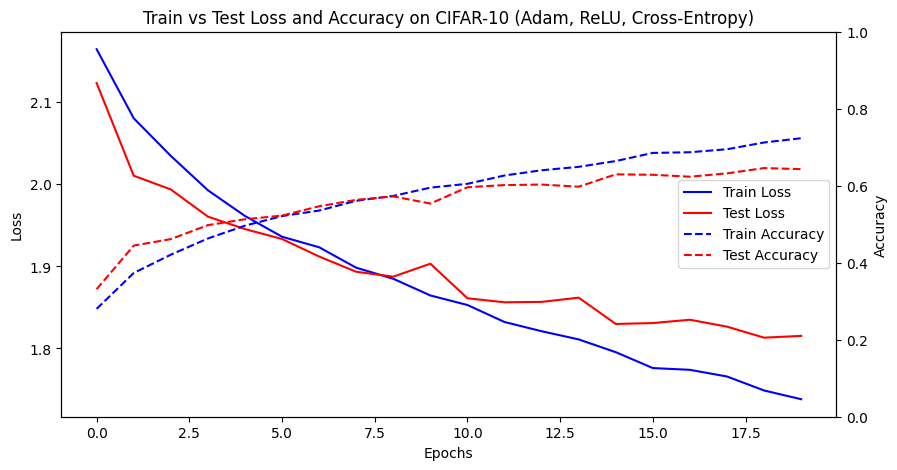

In [42]:
# Plot Train Loss vs Test Loss and Train Accuracy vs Test Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting Train and Test Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')

train_loss_line, = ax1.plot(train_losses, label='Train Loss', color='blue')
val_loss_line, = ax1.plot(val_losses, label='Test Loss', color='red')

ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='black')

ax2.set_ylim(0.0, 1.0)  # Set the right axis for accuracy from 0 to 1

train_acc_line, = ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
val_acc_line, = ax2.plot(val_accuracies, label='Test Accuracy', color='red', linestyle='--')

ax2.tick_params(axis='y')

# Adding legend for both axes
lines = [train_loss_line, val_loss_line, train_acc_line, val_acc_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

# Title for the plot
plt.title('Train vs Test Loss and Accuracy on CIFAR-10 (Adam, ReLU, Cross-Entropy)')
plt.show()